# Using Kalman filters to combine measurments from phone IMU and Bonsai position tracking

In [2]:
import numpy as np
import pandas as pd
import random
import logging
import datetime
import threading
import matplotlib.pyplot as plt
import seaborn as sns

## Importing and cleaning the data

### Data from Bonsai system

In [57]:
bons_pos_raw = pd.read_csv('position.csv')

In [58]:
bons_pos_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 2 columns):
x    933 non-null float64
y    1068 non-null object
dtypes: float64(1), object(1)
memory usage: 16.8+ KB


In [59]:
# convert y from object to float 
yy = pd.to_numeric(bons_pos_raw['y'] ,errors='coerce')
y = yy.to_frame()
position = pd.concat([bons_pos_raw['x'],y],axis=1)
position.describe()

,x,y
count,933.000000,933.000000
mean,321.048950,265.345725
std,85.824649,35.988839
min,118.878900,171.172300
25%,249.661600,227.664500
50%,343.273500,271.978600
75%,383.643900,297.178700
max,510.224400,334.433000


~~For NaN values, we are going to propagate last valid observation forward to next valid backfill.~~ Found out that there is .interpolate() which does linear interpolation between the last and next valid values. This would give better approximation of the NaN values.

In [60]:
# position = position.fillna(method='ffill')
position = position.interpolate()

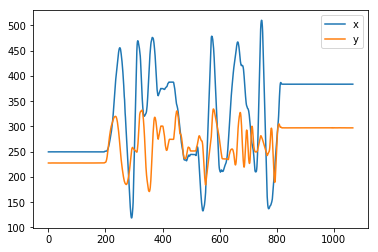

In [61]:
position.plot()

We will take into account data from 'timestamps' 200 to 820.

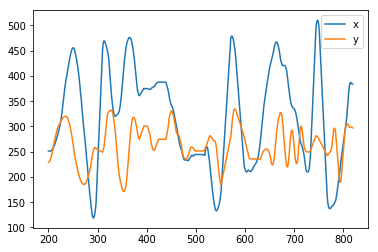

In [62]:
position.drop(position.index[820:], inplace=True)
position.drop(position.index[:200], inplace=True)
position.plot()

In [63]:
position = position.reset_index() #adjust the index to start from 0
position = position[['x','y']]
position.head()

,x,y
0,251.2055,228.9303
1,251.2724,229.3944
2,251.1937,230.4807
3,251.1713,232.1123
4,251.2639,234.3289


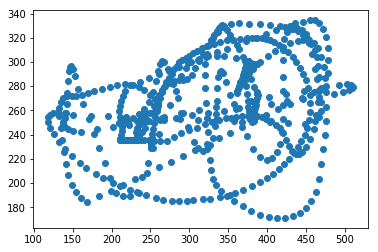

In [64]:
plt.scatter(position['x'],position['y'])
plt.show()

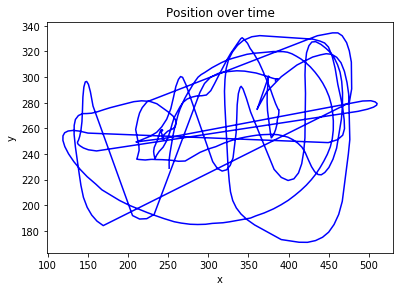

In [65]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

axes.plot(position['x'], position['y'], 'b')

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Position over time');

## Data from phone IMU

In [66]:
acc_raw = pd.read_csv('accelerometer.csv')

In [67]:
acc_raw.describe()

,id,attr_time,attr_x,attr_y,attr_z
count,6453.000000,6.453000e+03,6453.000000,6453.000000,6453.000000
mean,3227.000000,1.518811e+12,0.106636,0.020963,9.833243
std,1862.964976,1.863111e+04,0.393891,0.322731,0.112841
min,1.000000,1.518811e+12,-2.590610,-2.403850,5.209940
25%,1614.000000,1.518811e+12,0.076617,0.019154,9.814130
50%,3227.000000,1.518811e+12,0.105348,0.059857,9.828500
75%,4840.000000,1.518811e+12,0.131685,0.067040,9.847650
max,6453.000000,1.518811e+12,3.098190,2.990450,11.305800


In [68]:
acc = pd.concat([acc_raw['attr_x'],acc_raw['attr_y']],axis=1)

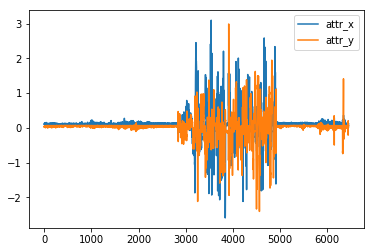

In [69]:
acc.plot()

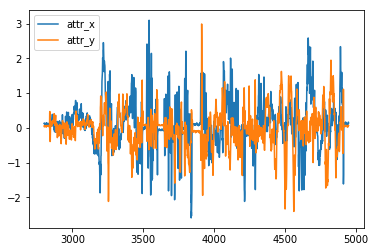

In [70]:
acc.drop(acc.index[4950:], inplace=True)
acc.drop(acc.index[:2800], inplace=True)
acc.plot()

In [71]:
acc = acc.reset_index() #adjust the index to start from 0
acc = acc[['attr_x','attr_y']]
acc.head()

,attr_x,attr_y
0,0.126897,0.055068
1,0.141262,0.031126
2,0.134079,0.028731
3,0.107742,0.059857
4,0.110137,0.067040


In [72]:
gyro_raw = pd.read_csv('gyro.csv')

In [73]:
gyro_raw.describe()

,id,attr_time,attr_x,attr_y,attr_z
count,3060.000000,3.060000e+03,3060.000000,3060.000000,3060.000000
mean,1530.500000,1.518811e+12,0.005933,-0.007774,-0.107164
std,883.490238,1.766810e+04,0.304358,0.508594,0.531026
min,1.000000,1.518811e+12,-0.091630,-28.121800,-10.294300
25%,765.750000,1.518811e+12,-0.001222,-0.001222,-0.001222
50%,1530.500000,1.518811e+12,0.001222,0.000000,0.000000
75%,2295.250000,1.518811e+12,0.002443,0.002443,0.001222
max,3060.000000,1.518811e+12,16.830600,0.262672,1.839930


In [74]:
gyro = gyro_raw['attr_z']

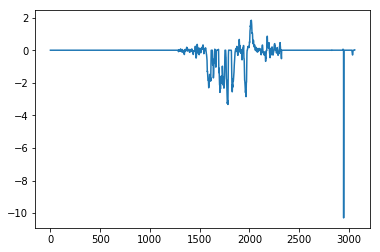

In [75]:
gyro.plot()

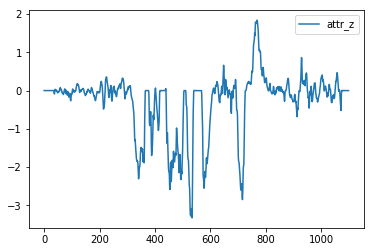

In [76]:
gyro.drop(gyro.index[2350:], inplace=True)
gyro.drop(gyro.index[:1250], inplace=True)
gyro = gyro.reset_index() #adjust the index to start from 0
gyro = gyro[['attr_z']]
gyro.plot()

## Integrating accelerometer and gyroscope data to get position

We first have to align the lengths of each of the sensors (it would be good if we do not need to do that for the IMU)

In [77]:
print(len(acc),len(gyro))

2150 1100


In [115]:
theta = acc[['attr_x']].copy() # just initialize a dataframe of the same size as acc
theta.rename( columns={'attr_x':'z'},inplace=True)

In [293]:
dt = 0.09
last_theta = 0
for i in range(len(theta)):
    if i%2==0:
        ind = np.floor(22/43*i)
        theta['z'][i] = last_theta + dt*gyro['attr_z'][ind] # integrate angular velocity to angular displacement
        last_theta = theta['z'][i]
    else:
        theta['z'][i] = "NaN"

In [266]:
theta = theta.interpolate()

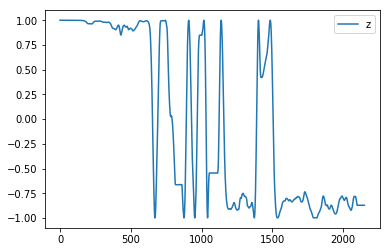

In [267]:
cos = theta.copy()
cos = cos.apply(lambda x: np.cos(x))
cos.plot()

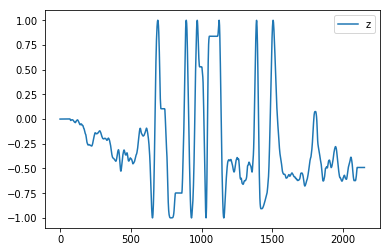

In [268]:
sin = theta.copy()
sin = sin.apply(lambda x: np.sin(x))
sin.plot()

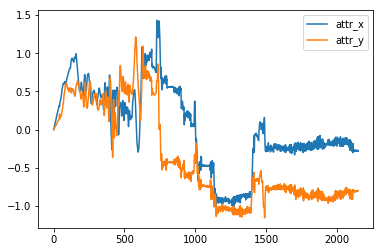

In [285]:
dt = 0.07
current_theta = 0
velocity = acc.copy()
velocity['attr_x'][0] = 0
velocity['attr_y'][0] = 0
for i in range(len(acc)-1):
    current_theta += theta['z'][i+1]
    cos_th = np.cos(current_theta)
    sin_th = np.sin(current_theta)
    velocity['attr_x'][i+1] = velocity['attr_x'][i] + dt*(acc['attr_x'][i]*cos_th + acc['attr_y'][i]*sin_th)
    velocity['attr_y'][i+1] = velocity['attr_y'][i] + dt*(acc['attr_y'][i]*cos_th - acc['attr_x'][i]*sin_th)
velocity.plot()

In [292]:
init_x = 251.2
init_y = 228.9
current_theta = 0
displacement = velocity.copy()
displacement['attr_x'][0] = init_x
displacement['attr_y'][0] = init_y
for i in range(len(velocity)-1):
    displacement['attr_x'][i+1] = displacement['attr_x'][i] + dt*velocity['attr_x'][i]
    displacement['attr_y'][i+1] = displacement['attr_y'][i] + dt*velocity['attr_y'][i]    
displacement.tail()

,attr_x,attr_y
2145,254.624055,176.364828
2146,254.604616,176.308194
2147,254.585629,176.252085
2148,254.565995,176.195893
2149,254.547102,176.139547


Let's compare how far off we are with the position measurements.

In [290]:
position.tail()

,x,y
615,386.8278,298.4508
616,385.6498,298.5864
617,384.0569,298.0928
618,383.6670,297.2396
619,383.6232,297.1292


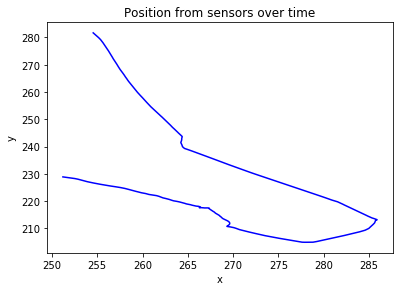

In [291]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

axes.plot(displacement['attr_x'], displacement['attr_y'], 'b')

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Position from sensors over time');

Hmm, nothing do with

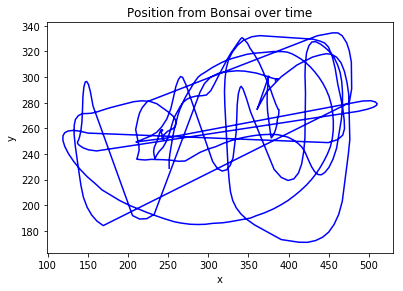

In [232]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

axes.plot(position['x'], position['y'], 'b')

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Position from Bonsai over time');

## Applying Kalman Filters

In [221]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

In [224]:
def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return np.dot(F, x)

def h_cv(x):
    return np.array([x[0], x[2]])
std_x, std_y = .3, .3
xs, _, _, _ = kf.batch_filter(zs)
zs = [np.array([i + randn()*std_x, 
                i + randn()*std_y]) for i in range(100)]               
sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=1.0, points=sigmas)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

uxs = []
for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2])
print('UKF standard deviation {:.3f} meters'.format(np.std(uxs - xs)))

NameError: name 'kf' is not defined